[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/04-pytorch-mnist.ipynb)


#Install packages and ngrok

In [ ]:
!pip install torch torchvision

In [ ]:
# Install ngrok
!pip install pyngrok

In [ ]:
!pip install email-validator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 15.1 MB/s eta 0:00:00


Go to https://ngrok.com/ and login with your Google account.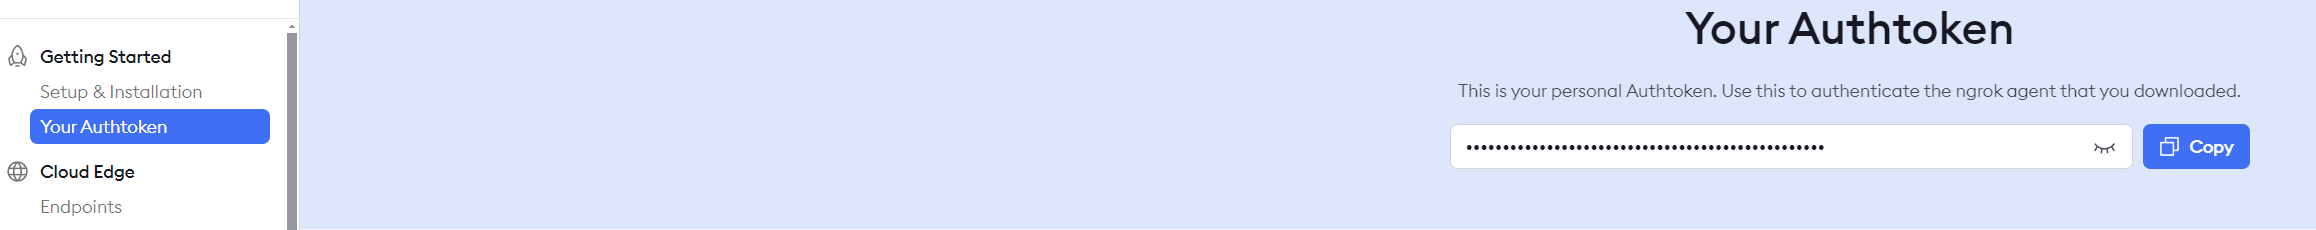

Then, navigate to 'Your Authtoken,' copy your token, and use it to replace 'your_ngrok_auth_token' below.

In [ ]:
# Set ngrok authtoken
from pyngrok import ngrok
ngrok.set_auth_token("Your Authtoken")

In [ ]:
# Function to start ngrok
def start_ngrok():
    # Start the ngrok process with subprocess, specifying that ngrok should tunnel HTTP traffic to port 5000
    ngrok_process = subprocess.Popen(['ngrok', 'http', '5000'])
    # Delay the script for 4 seconds to allow ngrok time to initialize and start the tunnel
    time.sleep(4)
    # Fetch the ngrok tunnel information using an HTTP GET request to ngrok's local API
    response = requests.get('http://localhost:4040/api/tunnels')
    # Parse the JSON response to get the details of the tunnel
    tunnel_info = response.json()
    # Extract the public URL where the ngrok tunnel is accessible
    public_url = tunnel_info['tunnels'][0]['public_url']
    # Print the ngrok tunnel URL to the console
    print(" * ngrok tunnel URL:", public_url)
    # Return the public URL for use elsewhere in the script
    return public_url

# With User Authentication and Enhanced Security

# ResNet with Flask

Upload imagenet_classes.txt:

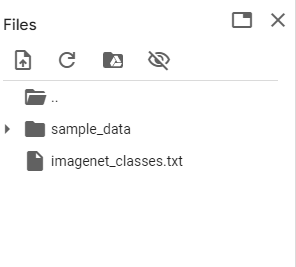

In [ ]:
# Import the required modules
import torch
from PIL import Image as PILImage
import torchvision.transforms as transforms
import torchvision.models as models
from flask import Flask, render_template_string, request, redirect, url_for, session
import os
from werkzeug.security import generate_password_hash, check_password_hash
from email_validator import validate_email, EmailNotValidError
import re
import subprocess
import requests
import time
import uuid

# Define a class for image classification using ResNet
class ResNetClassifier:
    def __init__(self, class_file='imagenet_classes.txt'):
        self.model = self.load_model()  # Load the model during initialization
        self.classes = self.load_classes(class_file)  # Load classes during initialization

    def load_model(self):
        # Load the pre-trained ResNet model
        model = models.resnet152(pretrained=True)
        model.eval()  # Set the model to evaluation mode
        return model

    def load_classes(self, class_file):
        # Load ImageNet classes
        with open(class_file) as f:
            classes = [line.strip() for line in f.readlines()]
        return classes

    def transform_image(self, image_path):
        # Define the image transformation pipeline
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # Open and transform the image
        image = PILImage.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)

    def predict_uploaded_image(self, image_path):
        # Transform the image
        image_tensor = self.transform_image(image_path)
        # Run the image through the model and get the predicted class
        with torch.no_grad():
            output = self.model(image_tensor)
            _, predicted = torch.max(output, 1)
        return self.classes[predicted.item()]

# Instantiate the classifier
classifier = ResNetClassifier()

# Initialize Flask app
app = Flask(__name__)
app.secret_key = os.urandom(24)  # Set a secret key for session management

# User data (in-memory storage for demonstration)
users = {}

# Set upload folder inside the static directory
UPLOAD_FOLDER = 'static/uploads'
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# HTML templates
register_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Register</title>
</head>
<body>
    <h1>Register</h1>
    <form method="post" action="/register">
        <label for="email">Email:</label>
        <input type="text" id="email" name="email" required><br>
        <label for="password">Password:</label>
        <input type="password" id="password" name="password" required><br>
        <button type="submit">Register</button>
    </form>
    <p>Already have an account? <a href="/login">Login here</a></p>
    {% if error %}
        <p style="color: red;">{{ error }}</p>
    {% endif %}
</body>
</html>
'''

login_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Login</title>
</head>
<body>
    <h1>Login</h1>
    <form method="post" action="/login">
        <label for="email">Email:</label>
        <input type="text" id="email" name="email" required><br>
        <label for="password">Password:</label>
        <input type="password" id="password" name="password" required><br>
        <button type="submit">Login</button>
    </form>
    <p>Don't have an account? <a href="/register">Register here</a></p>
    {% if error %}
        <p style="color: red;">{{ error }}</p>
    {% endif %}
</body>
</html>
'''

upload_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Classification</title>
</head>
<body>
    <h1>Upload an Image for Classification</h1>
    <form method="post" action="/" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*">
        <button type="submit">Upload</button>
    </form>
    {% if prediction %}
        <h2>Predicted Class: {{ prediction }}</h2>
        <img src="{{ url_for('static', filename='uploads/' + uploaded_file) }}" alt="Uploaded Image" style="max-width: 500px;">
    {% endif %}
    <br><br>
    <a href="/logout">Logout</a>
</body>
</html>
'''

# Password validation function
def validate_password(password):
    # Require at least 8 characters, one uppercase letter, one lowercase letter, one digit, and one special character
    if (len(password) >= 8 and
        re.search(r"[A-Z]", password) and
        re.search(r"[a-z]", password) and
        re.search(r"[0-9]", password) and
        re.search(r"[\W_]", password)):
        return True
    return False

# Route for registration page
@app.route('/register', methods=['GET', 'POST'])
def register():
    if request.method == 'POST':
        email = request.form['email']
        password = request.form['password']

        # Validate email format
        try:
            valid = validate_email(email)
            email = valid.email
        except EmailNotValidError as e:
            return render_template_string(register_template, error=str(e))

        # Check if the email is already registered
        if email in users:
            return render_template_string(register_template, error='Email is already registered.')

        # Validate password strength
        if not validate_password(password):
            return render_template_string(register_template, error='Password must be at least 8 characters long, contain an uppercase letter, a lowercase letter, a digit, and a special character.')

        # Hash the password before storing
        hashed_password = generate_password_hash(password)
        users[email] = hashed_password
        return redirect(url_for('login'))

    return render_template_string(register_template)

# Route for login page
@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        email = request.form['email']
        password = request.form['password']

        # Check if the email is registered
        if email in users and check_password_hash(users[email], password):
            session['email'] = email  # Store email in session
            return redirect(url_for('index'))
        else:
            return render_template_string(login_template, error='Invalid email or password.')

    return render_template_string(login_template)

# Route for logging out
@app.route('/logout')
def logout():
    # Clear the session
    session.pop('email', None)
    return redirect(url_for('login'))

# Route for the home page (requires login)
@app.route('/', methods=['GET', 'POST'])
def index():
    if 'email' not in session:
        return redirect(url_for('login'))

    prediction = None
    uploaded_file = None

    if request.method == 'POST':
        # Get the uploaded file
        file = request.files['file']
        if file:
            # Generate a unique filename using UUID
            unique_filename = f"{uuid.uuid4()}_{file.filename}"
            # Save the file to the upload folder inside the static directory
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], unique_filename)
            file.save(file_path)

            # Run prediction
            prediction = classifier.predict_uploaded_image(file_path)

            # Store the unique filename for display
            uploaded_file = unique_filename

    return render_template_string(upload_template, prediction=prediction, uploaded_file=uploaded_file)


# Main entry point of the application, this block runs when the script is executed directly
if __name__ == '__main__':
    # Start ngrok and store the public URL
    public_url = start_ngrok()
    # Print the public URL to access the web application
    print(f" * Access the web app at: {public_url}")
    # Run the Flask app on port 5000
    app.run(port=5000)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 125MB/s] 


 * ngrok tunnel URL: https://1fcb-34-87-41-216.ngrok-free.app
 * Access the web app at: https://1fcb-34-87-41-216.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:01:46] "GET / HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:01:47] "GET /login HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:01:47] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:01:58] "GET /register HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:02:13] "POST /register HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:02:14] "GET /login HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:02:27] "POST /login HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:02:27] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:02:40] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:02:40] "GET /static/uploads/27e8a9e3-dda5

# Database

In [ ]:
# Import the required modules
import torch
from PIL import Image as PILImage
import torchvision.transforms as transforms
import torchvision.models as models
from flask import Flask, render_template_string, request, redirect, url_for, session
import os
from werkzeug.security import generate_password_hash, check_password_hash
from email_validator import validate_email, EmailNotValidError
import re
import subprocess
import requests
import time
import uuid
import sqlite3

# Define a class for image classification using ResNet
class ResNetClassifier:
    def __init__(self, class_file='imagenet_classes.txt'):
        self.model = self.load_model()  # Load the model during initialization
        self.classes = self.load_classes(class_file)  # Load classes during initialization

    def load_model(self):
        # Load the pre-trained ResNet model
        model = models.resnet152(pretrained=True)
        model.eval()  # Set the model to evaluation mode
        return model

    def load_classes(self, class_file):
        # Load ImageNet classes
        with open(class_file) as f:
            classes = [line.strip() for line in f.readlines()]
        return classes

    def transform_image(self, image_path):
        # Define the image transformation pipeline
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # Open and transform the image
        image = PILImage.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)

    def predict_uploaded_image(self, image_path):
        # Transform the image
        image_tensor = self.transform_image(image_path)
        # Run the image through the model and get the predicted class
        with torch.no_grad():
            output = self.model(image_tensor)
            _, predicted = torch.max(output, 1)
        return self.classes[predicted.item()]

# Instantiate the classifier
classifier = ResNetClassifier()

# Initialize Flask app
app = Flask(__name__)
app.secret_key = os.urandom(24)  # Set a secret key for session management

# Set upload folder inside the static directory
UPLOAD_FOLDER = 'static/uploads'
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Database initialization function
def init_db():
    with sqlite3.connect("users.db") as conn:
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS users (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                email TEXT NOT NULL UNIQUE,
                password TEXT NOT NULL
            )
        ''')
        conn.commit()

# Call the database initialization function
init_db()

# HTML templates
register_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Register</title>
</head>
<body>
    <h1>Register</h1>
    <form method="post" action="/register">
        <label for="email">Email:</label>
        <input type="text" id="email" name="email" required><br>
        <label for="password">Password:</label>
        <input type="password" id="password" name="password" required><br>
        <button type="submit">Register</button>
    </form>
    <p>Already have an account? <a href="/login">Login here</a></p>
    {% if error %}
        <p style="color: red;">{{ error }}</p>
    {% endif %}
</body>
</html>
'''

login_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Login</title>
</head>
<body>
    <h1>Login</h1>
    <form method="post" action="/login">
        <label for="email">Email:</label>
        <input type="text" id="email" name="email" required><br>
        <label for="password">Password:</label>
        <input type="password" id="password" name="password" required><br>
        <button type="submit">Login</button>
    </form>
    <p>Don't have an account? <a href="/register">Register here</a></p>
    {% if error %}
        <p style="color: red;">{{ error }}</p>
    {% endif %}
</body>
</html>
'''

upload_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Classification</title>
</head>
<body>
    <h1>Upload an Image for Classification</h1>
    <form method="post" action="/" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*">
        <button type="submit">Upload</button>
    </form>
    {% if prediction %}
        <h2>Predicted Class: {{ prediction }}</h2>
        <img src="{{ url_for('static', filename='uploads/' + uploaded_file) }}" alt="Uploaded Image" style="max-width: 500px;">
    {% endif %}
    <br><br>
    <a href="/logout">Logout</a>
</body>
</html>
'''

# Password validation function
def validate_password(password):
    # Require at least 8 characters, one uppercase letter, one lowercase letter, one digit, and one special character
    if (len(password) >= 8 and
        re.search(r"[A-Z]", password) and
        re.search(r"[a-z]", password) and
        re.search(r"[0-9]", password) and
        re.search(r"[\W_]", password)):
        return True
    return False

# Route for registration page
@app.route('/register', methods=['GET', 'POST'])
def register():
    if request.method == 'POST':
        email = request.form['email']
        password = request.form['password']

        # Validate email format
        try:
            valid = validate_email(email)
            email = valid.email
        except EmailNotValidError as e:
            return render_template_string(register_template, error=str(e))

        # Validate password strength
        if not validate_password(password):
            return render_template_string(register_template, error='Password must be at least 8 characters long, contain an uppercase letter, a lowercase letter, a digit, and a special character.')

        # Hash the password before storing
        hashed_password = generate_password_hash(password)

        # Store user in the database
        with sqlite3.connect("users.db") as conn:
            cursor = conn.cursor()
            try:
                cursor.execute("INSERT INTO users (email, password) VALUES (?, ?)", (email, hashed_password))
                conn.commit()
            except sqlite3.IntegrityError:
                return render_template_string(register_template, error='Email is already registered.')

        return redirect(url_for('login'))

    return render_template_string(register_template)

# Route for login page
@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        email = request.form['email']
        password = request.form['password']

        # Check if the email is registered
        with sqlite3.connect("users.db") as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT password FROM users WHERE email = ?", (email,))
            row = cursor.fetchone()

        if row and check_password_hash(row[0], password):
            session['email'] = email  # Store email in session
            return redirect(url_for('index'))
        else:
            return render_template_string(login_template, error='Invalid email or password.')

    return render_template_string(login_template)

# Route for the home page (requires login)
@app.route('/', methods=['GET', 'POST'])
def index():
    if 'email' not in session:
        return redirect(url_for('login'))

    prediction = None
    uploaded_file = None

    if request.method == 'POST':
        # Get the uploaded file
        file = request.files['file']
        if file:
            # Generate a unique filename using UUID
            unique_filename = f"{uuid.uuid4()}_{file.filename}"
            # Save the file to the upload folder inside the static directory
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], unique_filename)
            file.save(file_path)

            # Run prediction
            prediction = classifier.predict_uploaded_image(file_path)

            # Store the unique filename for display
            uploaded_file = unique_filename

    return render_template_string(upload_template, prediction=prediction, uploaded_file=uploaded_file)

# Route for logout
@app.route('/logout')
def logout():
    session.pop('email', None)
    return redirect(url_for('login'))

# Main entry point of the application, this block runs when the script is executed directly
if __name__ == '__main__':
    # Start ngrok and store the public URL
    public_url = start_ngrok()
    # Print the public URL to access the web application
    print(f" * Access the web app at: {public_url}")
    # Run the Flask app on port 5000
    app.run(port=5000)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 * ngrok tunnel URL: https://dd59-34-87-41-216.ngrok-free.app
 * Access the web app at: https://dd59-34-87-41-216.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:04:36] "GET / HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:04:37] "GET /login HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:04:37] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:04:57] "GET /register HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:05:14] "POST /register HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:05:15] "GET /login HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:05:29] "POST /login HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:05:30] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:05:39] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Oct/2024 17:05:40] "GET /static/uploads/62062e7b-e7a6

# Exercise: Opening Limited Permissions to Non-Registered Users

Copy the above code from Database section and modify. Registered and non-registered users can both upload images for classification prediction. However, non-registered users cannot view the uploaded image on the fron-tend, whereas registered users can.

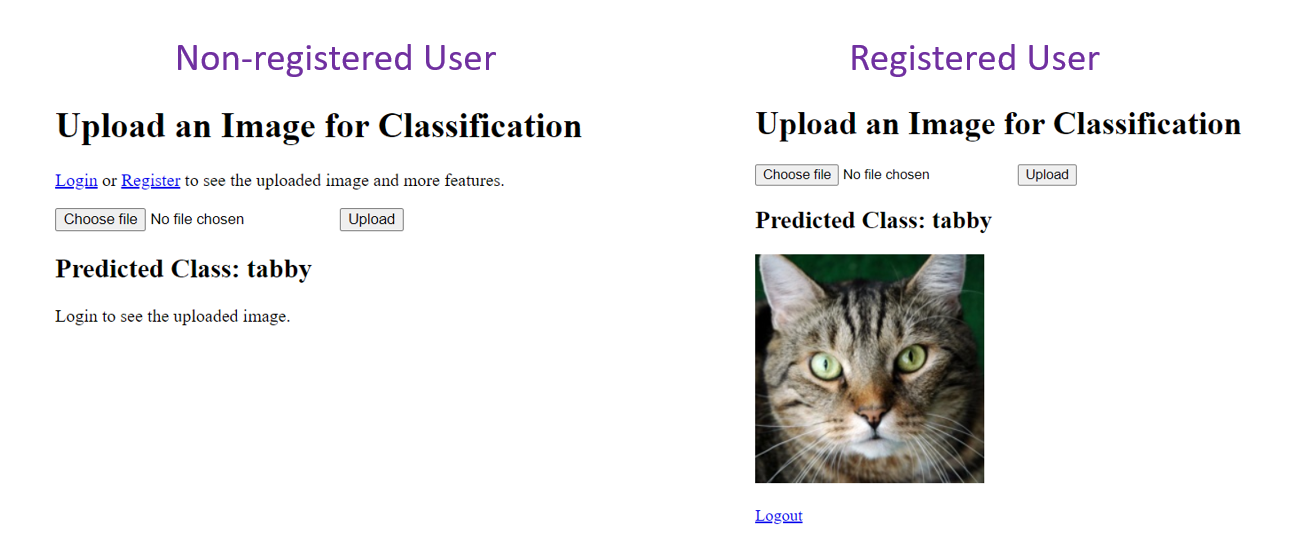